# OGGM - data pulling

## Setting up:

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
from pyproj import Transformer
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import cfg, utils, workflow, tasks
import os
import re
from collections import defaultdict
import seaborn as sns
import math
from os.path import isfile, join, isdir

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2025-01-20 10:18:14: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-01-20 10:18:14: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-01-20 10:18:14: oggm.cfg: Multiprocessing: using all available processors (N=32)
2025-01-20 10:18:14: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-01-20 10:18:14: oggm.cfg: Multiprocessing switched ON after user settings.
2025-01-20 10:18:14: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [2]:
def emptyfolder(path):
    if os.path.exists(path):
        # Loop through all items in the directory
        for item in os.listdir(path):
            item_path = join(path, item)
            if isfile(item_path):
                os.remove(item_path)  # Remove file
            elif isdir(item_path):
                emptyfolder(item_path)  # Recursively empty the folder
                os.rmdir(item_path)  # Remove the now-empty folder
    else:
        createPath(path)


def createPath(path):
    os.makedirs(path, exist_ok=True)

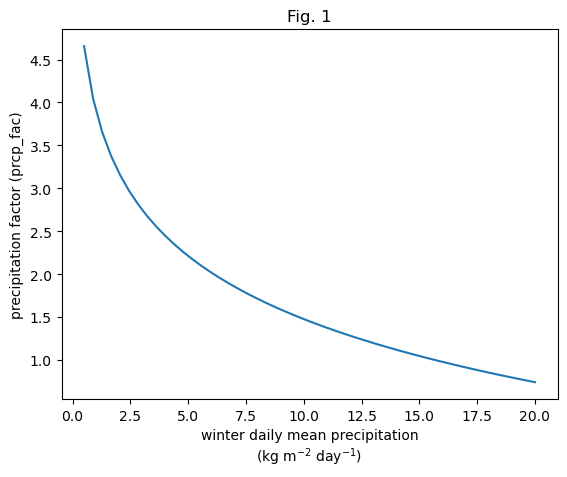

In [3]:
w_prcp_array = np.linspace(0.5, 20, 51)
# we basically do here the same as in massbalance.decide_winter_precip_factor(gdir)
a, b = cfg.PARAMS['winter_prcp_fac_ab']
r0, r1 = cfg.PARAMS['prcp_fac_min'], cfg.PARAMS['prcp_fac_max']
prcp_fac = a * np.log(w_prcp_array) + b
# don't allow extremely low/high prcp. factors!!!
prcp_fac_array = utils.clip_array(prcp_fac, r0, r1)
plt.plot(w_prcp_array, prcp_fac_array)
plt.xlabel(r'winter daily mean precipitation' + '\n' +
           r'(kg m$^{-2}$ day$^{-1}$)')
plt.ylabel('precipitation factor (prcp_fac)')
plt.title('Fig. 1')

# save arrays
np.save('w_prcp_array.npy', w_prcp_array)
np.save('prcp_fac_array.npy', prcp_fac_array)

## Download OGGM data:

In [4]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

In [5]:
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)

2025-01-20 10:18:16: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2025-01-20 10:18:16: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers


In [6]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    # tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2025-01-20 10:18:41: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


In [7]:
# save OGGM xr for all needed glaciers: 
emptyfolder('../../../data/OGGM/xr_grids/')
for gdir in tqdm(gdirs):
    RGIId = gdir.rgi_id
    # Get info of that sample:
    #POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # # Get oggm data for that RGI ID
    # for gdir in gdirs:
    #     if gdir.rgi_id == RGIId:
    #         break

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()
        
    # save ds
    ds.to_netcdf(f'../../../data/OGGM/xr_grids/{RGIId}.nc')

  0%|          | 0/3927 [00:00<?, ?it/s]

## Load PMB data:

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,RGI60-11.02764


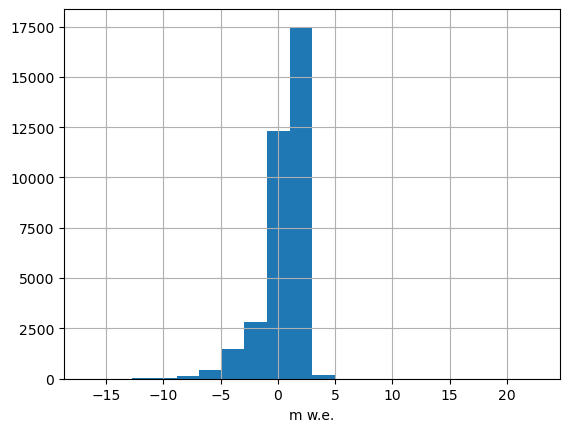

In [8]:
DF_TYPE = 'close'  # 'all' or 'close' depending on whether we also want snow probes

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'df_pmb_50s_clean_all.csv')
# Histogram of mass balance
df_pmb['POINT_BALANCE'].hist(bins=20)
plt.xlabel('m w.e.')
df_pmb.head(3)

In [9]:
# Get info of that sample:
i = 0
RGI = df_pmb.iloc[i].RGIId
POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
# gdir = find_gdir(gdirs, RGI)

with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

<xarray.Dataset>
Dimensions:                  (x: 133, y: 68)
Coordinates:
  * x                        (x) float32 -2.077e+03 -2.047e+03 ... 1.883e+03
  * y                        (y) float32 5.097e+06 5.097e+06 ... 5.095e+06
Data variables: (12/17)
    topo                     (y, x) float32 2.989e+03 2.996e+03 ... 3.613e+03
    topo_smoothed            (y, x) float32 3.007e+03 3.009e+03 ... 3.63e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.1747 0.1881 ... 0.3885 0.3636
    aspect                   (y, x) float32 5.814 5.666 5.472 ... 3.591 3.477
    slope_factor             (y, x) float32 2.849 2.725 2.51 ... 1.764 1.835
    dis_from_border          (y, x) float32 1.262e+03 1.253e+03 ... 834.1 852.8
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.87661 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      4145.0
    min_h_dem:      2858.0
    max_h_glacier:  4100.0
    min_h_glacier:  2976.0

## Merge with OGGM data:

In [10]:
# All possible variables of interest from oggm
# voi = [
#     "aspect", "slope", "dis_from_border", "topo", "hugonnet_dhdt",
#     "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
#     "millan_vy"
# ]

voi = [
    "aspect",
    "slope",
    "topo",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan
    
grouped = df_pmb.groupby("RGIId")

# Process each group
for rgi_id, group in grouped:
    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == rgi_id:
            break

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()
        
    # Define the coordinate transformation
    transf = pyproj.Transformer.from_proj(
        pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
        pyproj.CRS.from_user_input(ds.pyproj_srs),  # Output CRS from dataset
        always_xy=True
    )
    
    # Transform all coordinates in the group
    lon, lat = group["POINT_LON"].values, group["POINT_LAT"].values
    x_stake, y_stake = transf.transform(lon, lat)

    # Select nearest values for all points
    stake = ds.sel(
        x=xr.DataArray(x_stake, dims="points"),
        y=xr.DataArray(y_stake, dims="points"),
        method="nearest"
    )

    # Extract variables of interest
    stake_var = stake[voi]

    # Convert the extracted data to a DataFrame
    stake_var_df = stake_var.to_dataframe()

    # Update the DataFrame with the extracted values
    for var in voi:
        df_pmb.loc[group.index, var] = stake_var_df[var].values

# change from radians to degrees so that it agrees with sgi data
df_pmb['aspect'] = df_pmb['aspect'].apply(lambda x: math.degrees(x))
df_pmb['slope'] = df_pmb['slope'].apply(lambda x: math.degrees(x))

# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
              index=False)
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,RGI60-11.02764,256.726621,17.539690,3143.0,-1.284834,61.502941,0.503317


## Add SGI data:

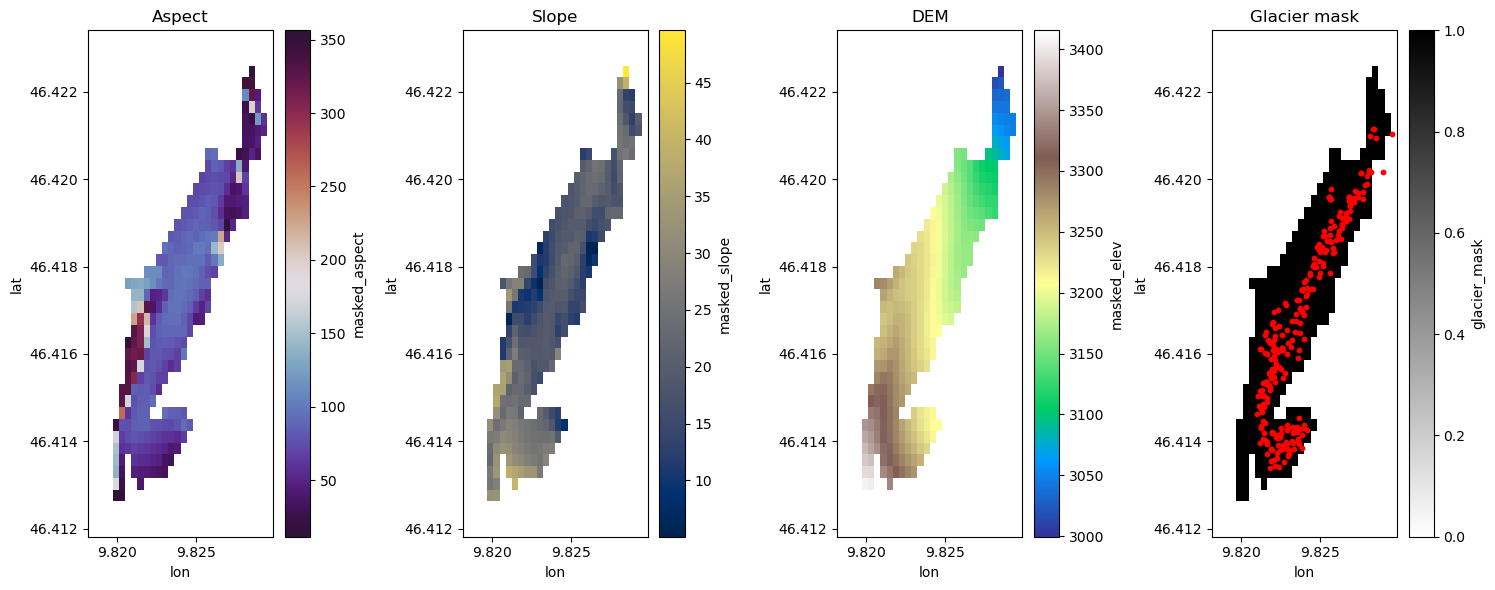

In [12]:
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

# Example
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
i = 0
GlacierName = 'corvatsch'
df_pmb_gl = df_pmb[df_pmb.GLACIER == GlacierName]

stake_coordinates = df_pmb_gl[['POINT_LON', 'POINT_LAT']].values
RGI, YEAR, GLACIER = df_pmb_gl.iloc[i].RGIId, df_pmb_gl.iloc[
    i].YEAR, df_pmb_gl.iloc[i].GLACIER
POINT_LAT, POINT_LON = df_pmb_gl.iloc[i].POINT_LAT, df_pmb_gl.iloc[i].POINT_LON

# Open SGI grid:
ds_sgi = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                         f'{GlacierName}.nc')

stake = ds_sgi.sel(lon=POINT_LON, lat=POINT_LAT, method="nearest")

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_sgi.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_sgi.masked_slope.plot(ax=axs[1], cmap='cividis')
ds_sgi.masked_elev.plot(ax=axs[2], cmap='terrain')
ds_sgi.glacier_mask.plot(ax=axs[3], cmap='binary')
axs[3].scatter(stake_coordinates[:, 0], stake_coordinates[:, 1], c='r', s=10)
axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [14]:
# Paths and variables of interest
path_SGI_topo = '../../../data/GLAMOS/topo/SGI2020/'
path_masked_grids = os.path.join(path_SGI_topo, 'xr_masked_grids/')
voi = ["masked_aspect", "masked_slope", "masked_elev"]

# Get fully processed glacier names
fully_processed = set(
    re.split(r'.nc', f)[0] for f in os.listdir(path_masked_grids) if f.endswith('.nc')
)

# Filter DataFrame for fully processed glaciers
df_pmb_filtered = df_pmb[df_pmb.GLACIER.isin(fully_processed)].copy()

# Initialize empty columns for variables of interest
for var in voi:
    df_pmb_filtered[var] = np.nan

# Group rows by glacier name to process each glacier in bulk
grouped = df_pmb_filtered.groupby("GLACIER")

# Process each glacier
for glacier_name, group in tqdm(grouped, desc="Processing glaciers"):
    try:
        # Open the dataset for the current glacier
        file_path = os.path.join(path_masked_grids, f"{glacier_name}.nc")
        ds_sgi = xr.open_dataset(file_path)

        # Transform coordinates for the group
        lon = group["POINT_LON"].values
        lat = group["POINT_LAT"].values

        # Select nearest values for all points in the group
        stake = ds_sgi.sel(
            lon=xr.DataArray(lon, dims="points"),
            lat=xr.DataArray(lat, dims="points"),
            method="nearest"
        )

        # Extract variables of interest and convert to a DataFrame
        stake_var = stake[voi].to_dataframe().reset_index()

        # Map extracted values back to the original DataFrame
        for var in voi:
            df_pmb_filtered.loc[group.index, var] = stake_var[var].values
    except FileNotFoundError:
        print(f"File not found for glacier: {glacier_name}")
        continue

# Rename columns
df_pmb_filtered.rename(columns={
    "masked_aspect": "aspect_sgi",
    "masked_slope": "slope_sgi",
    "masked_elev": "topo_sgi"
}, inplace=True)

# Save to CSV
output_path = os.path.join(path_PMB_GLAMOS_csv, 'CH_wgms_dataset_all.csv')
df_pmb_filtered.to_csv(output_path, index=False)

# Display the first few rows
print(df_pmb_filtered.head(3))

Processing glaciers:   0%|          | 0/32 [00:00<?, ?it/s]

   YEAR POINT_ID GLACIER  FROM_DATE   TO_DATE  POINT_LAT  POINT_LON  \
0  2006      100   adler   20051017  20061011  46.010637   7.855896   
1  2006      200   adler   20051017  20061011  46.010052   7.858628   
2  2006      300   adler   20051017  20061011  46.010646   7.860957   

   POINT_ELEVATION  POINT_BALANCE  PERIOD           RGIId      aspect  \
0      3096.507742         -2.592  annual  RGI60-11.02764  254.483669   
1      3141.506520         -2.502  annual  RGI60-11.02764  273.466595   
2      3191.502735         -2.592  annual  RGI60-11.02764  256.726621   

       slope    topo  hugonnet_dhdt  consensus_ice_thickness  millan_v  \
0  19.483581  3039.0      -1.504815                43.181839  3.591626   
1  12.549861  3091.0      -0.970061                41.090096  0.975349   
2  17.539690  3143.0      -1.284834                61.502941  0.503317   

   aspect_sgi  slope_sgi     topo_sgi  
0  286.843880  20.604390  3018.033333  
1  258.181463  12.582387  3077.711111  
2  23

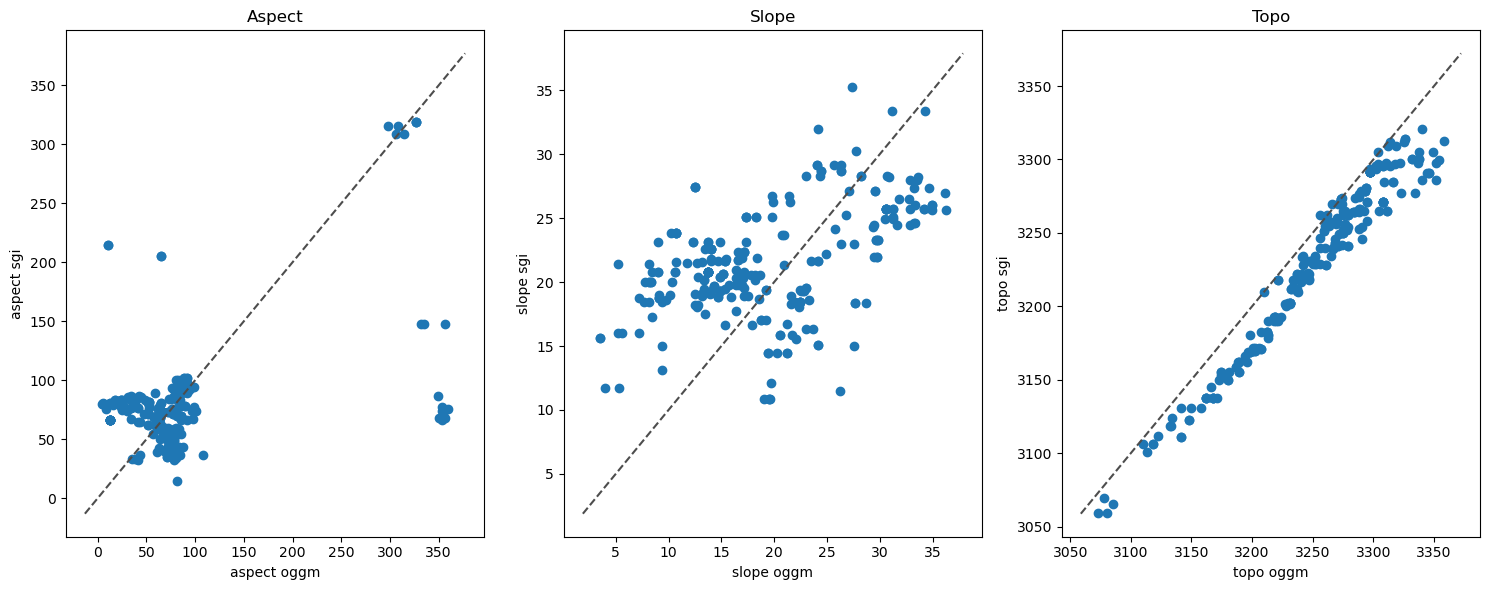

In [15]:
glacierName = 'corvatsch'
df_pmb_gl = df_pmb_filtered[(df_pmb_filtered.GLACIER == glacierName)]

# Plot aspect and sgi aspect
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].scatter(df_pmb_gl.aspect, df_pmb_gl.aspect_sgi)
axs[0].set_xlabel('aspect oggm')
axs[0].set_ylabel('aspect sgi')
axs[0].set_title('Aspect')

axs[1].scatter(df_pmb_gl.slope, df_pmb_gl.slope_sgi)
axs[1].set_xlabel('slope oggm')
axs[1].set_ylabel('slope sgi')
axs[1].set_title('Slope')

# same for topo
axs[2].scatter(df_pmb_gl.topo, df_pmb_gl.topo_sgi)
axs[2].set_xlabel('topo oggm')
axs[2].set_ylabel('topo sgi')
axs[2].set_title('Topo')
# add 1:1 line
for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

plt.tight_layout()

## Add avalanche data:

In [ ]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~mkneib/global_whypso/'
gdirs = workflow.init_glacier_directories(
    rgidf,
    prepro_base_url=base_url,
    from_prepro_level=3,
    prepro_border=80,
    reset=True,
    force=True,
)

In [ ]:
gdir = gdirs[0]
# Get the path to the gridded data file & open it
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds.snowslide_1m.where(ds.glacier_mask).plot()
plt.show()

In [ ]:
# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'

df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')
df_pmb.head(3)

In [ ]:
# variables of interest from oggm
voi = ["snowslide_1m"]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()

In [ ]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
              index=False)

In [ ]:
# Plot distribution of snowslide_1m:
df_pmb['snowslide_1m'].hist(bins=20)

In [ ]:
# Find glaciers with snowslide_1m > 1:
df_pmb[df_pmb['snowslide_1m'] > 1]

In [ ]:
df_pmb_subset = df_pmb[(df_pmb.GLACIER == 'tsanfleuron')
                       & (df_pmb.YEAR > 2010)]
x_stakes, y_stakes, snowslide_1m_ = [], [], []
for i in tqdm(range(len((df_pmb_subset))), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb_subset.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb_subset.iloc[i].POINT_LAT, df_pmb_subset.iloc[
        i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    x_stakes.append(x_stake)
    y_stakes.append(y_stake)
    snowslide_1m_.append(stake.snowslide_1m.values)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
ds.snowslide_1m.where(ds.glacier_mask).plot()
# plot stake
for x_stake, y_stake in zip(x_stakes, y_stakes):
    plt.scatter(x_stake, y_stake, color='r')

# plot distribution of snowslide_1m
plt.subplot(1, 2, 2)
plt.hist(snowslide_1m_)
plt.tight_layout()